# ACS Analysis for Ocean Optics Cruise


Goals
- ingest TSG data and map it out
- analyze the ACS data for abs line height and compare to chla
- cluster the ACS data and compare it to location, S and T via TSG metadata

#### Bring in all the necessary packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import least_squares
import math
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import hvplot.pandas
import pandas as pd

Pull in TSG data

In [7]:
tsg_df = pd.read_csv('data/TSG_20210804_prod_a.csv')

In [8]:
tsg_df['pydt'] = pd.to_datetime(tsg_df.dt-719529, unit='D')

In [9]:
tsg_df.head()

dt        lat  lat_avg_sd  lat_avg_n        lon  lon_avg_sd  \
0  738372.513889  43.793734    0.000393         37 -69.964794    0.000630   
1  738372.514583  43.792031    0.000552         43 -69.967265    0.000746   
2  738372.515278  43.789918    0.000672         44 -69.969485    0.000557   
3  738372.515972  43.787496    0.000730         44 -69.971140    0.000431   
4  738372.516667  43.784969    0.000718         43 -69.972689    0.000432   

   lon_avg_n          t  t_avg_sd  t_avg_n         c  c_avg_sd  c_avg_n  \
0         37  18.143949  0.061887       37  4.113721  0.001875       37   
1         43  17.946267  0.046138       43  4.115473  0.001269       43   
2         44  17.808039  0.036552       44  4.111494  0.001412       44   
3         44  17.693482  0.026050       44  4.108812  0.000891       44   
4         43  17.627528  0.012824       43  4.110318  0.000572       43   

           s  s_avg_sd  s_avg_n      sigma  sigma_avg_sd  sigma_avg_n  \
0  30.858462  0.034650       37  22.069486      0.041102           37   
1  31.022556  0.036129       43  22.242419      0.038317           43   
2  31.094184  0.017396       44  22.330218      0.021869           44   
3  31.159048  0.026448       44  22.407107      0.026369           44   
4  31.222326  0.014011       43  22.471177      0.013713           43   

                           pydt  
0 2021-08-04 12:20:00.000008960  
1 2021-08-04 12:20:59.999975168  
2 2021-08-04 12:22:00.000022016  
3 2021-08-04 12:22:59.999977984  
4 2021-08-04 12:24:00.000024832

In [10]:
tsg_df.hvplot.points('lon', 'lat', geo=True, c='t', alpha=0.2, cmap='inferno', tiles='CartoLight', width=300, height=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (t)

In [11]:
tsg_df.hvplot.points('lon', 'lat', geo=True, c='s', alpha=0.2, cmap='viridis', tiles='CartoLight', width=300, height=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (s)

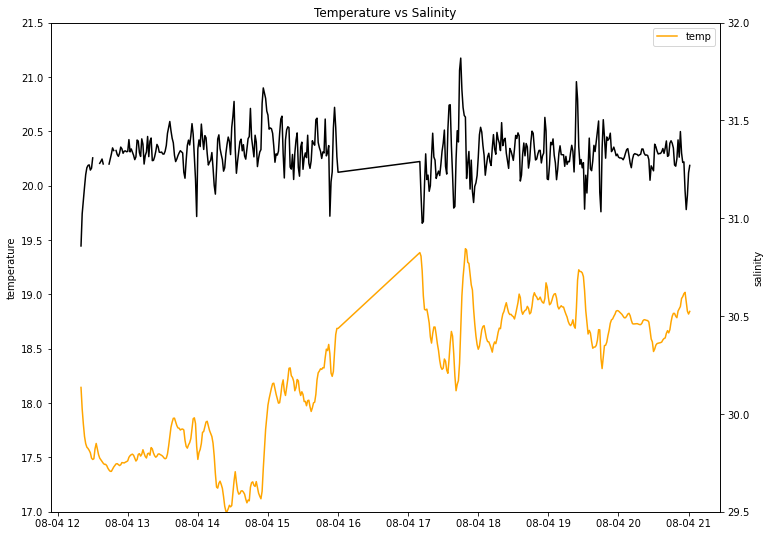

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(tsg_df.pydt, tsg_df.t, color='orange', label='temp')
ax.set_ylim(17,21.5)
ax.set_ylabel('temperature')
ax2 = ax.twinx()
ax2.plot(tsg_df.pydt, tsg_df.s, color='black', label='salinity')
ax2.set_ylim(29.5,32)
ax2.set_ylabel('salinity')
ax.set_title('Temperature vs Salinity')
ax.legend()

In [13]:
tsg_gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(x=tsg_df.lon, y=tsg_df.lat)
)

Pull in ACS data from Inline Analysis

In [14]:
acs_wavelength = np.genfromtxt('data/acs_lambda_a.csv', delimiter=',')

In [15]:
acs_tsw_df =  pd.read_csv('data/ACS94_20210804_bin_tsw.csv')

In [16]:
acs_tsw_bin = acs_tsw_df.iloc[:,5+81*2:5+81*3]

In [17]:
acs_tsw_df['pydt'] =  pd.to_datetime(pd.read_csv('data/ACS94_20210804_bin_tsw.csv').dt-719529, unit='D')

In [18]:
acs_dt = pd.to_datetime(pd.read_csv('data/ACS94_20210804_bin_tsw.csv').dt-719529, unit='D')

In [20]:
acs_fsw_bin = pd.read_csv('data/ACS94_20210804_bin_fsw.csv').iloc[:,5+81*2:5+81*3]

In [21]:
acs_fsw_dt = pd.to_datetime(pd.read_csv('data/ACS94_20210804_bin_fsw.csv').dt-719529, unit='D')

In [104]:
pd.read_csv('data/ACS94_20210804_prod_p.csv').iloc[:,344]

0      0.657053
1      0.659579
2      0.649503
3      0.656144
4      0.657117
         ...   
262    0.359321
263    0.436932
264    0.466584
265    0.452299
266    0.410334
Name: gamma, Length: 267, dtype: float64

In [22]:
acs_part_bin = pd.read_csv('data/ACS94_20210804_prod_p.csv').iloc[:,1:82]

acs_part_bin.head()

ap_1      ap_2      ap_3      ap_4      ap_5      ap_6      ap_7  \
0  0.184414  0.172569  0.184996  0.184954  0.182519  0.182267  0.180251   
1  0.196775  0.191757  0.192959  0.193764  0.193291  0.192264  0.187649   
2  0.203073  0.201372  0.198590  0.200061  0.198988  0.197147  0.192627   
3  0.203310  0.201507  0.200884  0.201396  0.200415  0.198505  0.194416   
4  0.205612  0.202919  0.200692  0.200769  0.203061  0.199174  0.194842   

       ap_8      ap_9     ap_10  ...     ap_72    ap_73     ap_74     ap_75  \
0  0.178508  0.172987  0.165339  ...  0.000893  0.00074  0.001949  0.001156   
1  0.186497  0.181050  0.173120  ...       NaN      NaN       NaN       NaN   
2  0.190925  0.184956  0.177000  ...       NaN      NaN       NaN       NaN   
3  0.193029  0.186117  0.179152  ...       NaN      NaN       NaN       NaN   
4  0.193187  0.187059  0.179873  ...       NaN      NaN       NaN       NaN   

      ap_76     ap_77  ap_78  ap_79  ap_80  ap_81  
0  0.000357  0.000137    NaN    NaN    NaN    NaN  
1       NaN       NaN    NaN    NaN    NaN    NaN  
2       NaN       NaN    NaN    NaN    NaN    NaN  
3       NaN       NaN    NaN    NaN    NaN    NaN  
4       NaN       NaN    NaN    NaN    NaN    NaN  

[5 rows x 81 columns]

In [23]:
plt.rcParams.update({'font.size': 20})

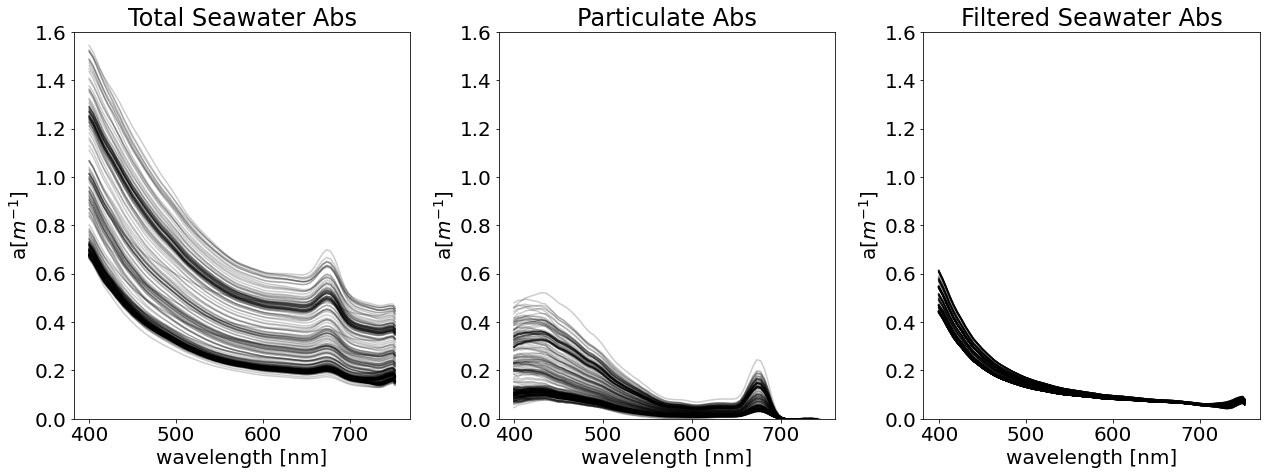

In [24]:
acs_tsw_bin_np = acs_tsw_bin.to_numpy()
acs_part_bin_np = acs_part_bin.to_numpy()
acs_fsw_bin_np = acs_fsw_bin.to_numpy()

fig, ax = plt.subplots(1,3, figsize=(18,7))
for i in range(acs_tsw_bin_np.shape[0]):
    ax[0].plot(acs_wavelength,acs_tsw_bin_np[i,:], color='black', alpha=0.2)
ax[0].set_ylim(0,1.6)
ax[0].set_title('Total Seawater Abs')
ax[0].set_ylabel('a[$m^{-1}$]')
ax[0].set_xlabel('wavelength [nm]')
    
for i in range(acs_part_bin_np.shape[0]):
    ax[1].plot(acs_wavelength,acs_part_bin_np[i,:], color='black', alpha=0.2)
ax[1].set_ylim(0,1.6)
ax[1].set_title('Particulate Abs')
ax[1].set_ylabel('a[$m^{-1}$]')
ax[1].set_xlabel('wavelength [nm]')    

for i in range(acs_fsw_bin_np.shape[0]):
    ax[2].plot(acs_wavelength,acs_fsw_bin_np[i,:], color='black', alpha=0.2)
ax[2].set_ylim(0,1.6)
ax[2].set_title('Filtered Seawater Abs')
ax[2].set_ylabel('a[$m^{-1}$]')
ax[2].set_xlabel('wavelength [nm]')

fig.tight_layout()
fig.savefig('cruise_abs_spec_again.png')

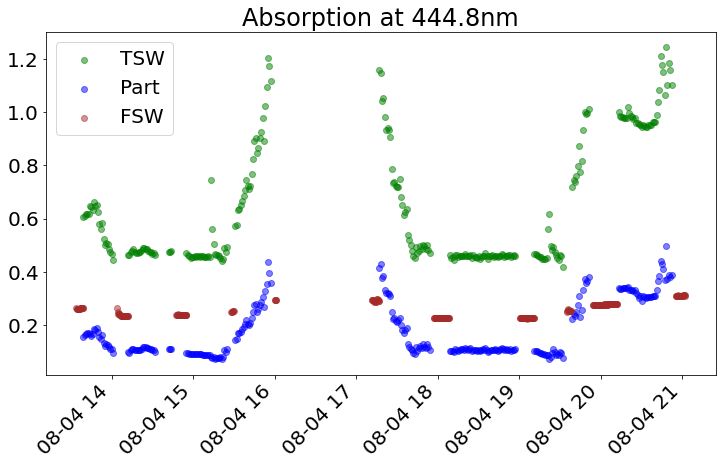

In [63]:
fig, ax = plt.subplots(figsize=(12,7))
for i in range(acs_tsw_bin_np.shape[0]):
    ax.scatter(acs_dt[i], acs_tsw_bin_np[i,10], color='Green', alpha=0.5, label='TSW' if i == 0 else "")

for i in range(acs_part_bin_np.shape[0]):
    ax.scatter(acs_dt[i], acs_part_bin_np[i,10], color='Blue', alpha=0.5, label='Part'if i == 0 else "")
    
for i in range(acs_fsw_bin_np.shape[0]):
    ax.scatter(acs_fsw_dt[i], acs_fsw_bin_np[i,10], color='Brown', alpha=0.5, label='FSW'if i == 0 else "")
ax.set_title('Absorption at ' + str(acs_wavelength[10]) + 'nm')

fig.autofmt_xdate(rotation=45)

ax.legend()
plt.savefig('tsw_fsw_part.png')

### Map out Abs Line Height
Find the nearest ACS wavenelghts to 650 and 715

Then find the max value there, then interpolate across that line and find the diff and divide by 0.11

Run through each line and fine the 

In [26]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

In [27]:
def abs_line_height(wavelength, abs_spectra, plot=False):
    idx650 = find_nearest(wavelength, 650)
    idx715 = find_nearest(wavelength, 715)
    
    # TODO this may or may not be appropriate to set this to 0 but some red/NIR values are nan and need it to calculate 
    where_are_NaNs = np.isnan(abs_spectra)
    abs_spectra[where_are_NaNs] = 0
    
    interp_line_fx = interpolate.interp1d([wavelength[idx650], wavelength[idx715]], [abs_spectra[idx650], abs_spectra[idx715]])
    
    max_arg = np.argmax(abs_spectra[idx650:idx715]) + idx650
    
    interp_line_value = interp_line_fx(wavelength[max_arg])

    abs_peak = abs_spectra[max_arg]
    # 0.011 value is determined by Roseler et al paper based on global dataset
    chla_estimate = (abs_peak - interp_line_value) / 0.011
    
    if plot:
        fig, ax = plt.subplots(figsize=(10,7))

        ax.plot(wavelength, abs_spectra, color='black', label='Particulate Abs')
        ax.set_ylim(-0.05,0.40)
        ax.set_xlim(380, 850)
        ax.axhline(0)

        ax.plot([wavelength[max_arg],wavelength[max_arg]], [interp_line_value,abs_peak], color='red', linestyle='--', label='line height')
        ax.plot([wavelength[idx650], wavelength[idx715]], [abs_spectra[idx650], abs_spectra[idx715]], 
                color='grey', linestyle='--', label='interp line')
        ax.legend()
        ax.set_ylabel('a[$m^{-1}$]')
        ax.set_xlabel('wavelength [nm]')
        ax.set_title('Abs Line Height of Particulates')
        fig.show()

        #fig.savefig('abs_line_height.png',dpi=250)
        
    return(chla_estimate)

In [28]:
acs_part_bin_np[0].shape

(81,)

In [29]:
acs_wavelength[52], acs_wavelength[68]

(650.2, 716.6)

In [30]:
abs_line_chla = []
for i in range(acs_part_bin_np.shape[0]):
    abs_line_chla.append(abs_line_height(acs_wavelength,acs_part_bin_np[i], plot=False))

In [112]:
acs_fsw_dt.shape

(247,)

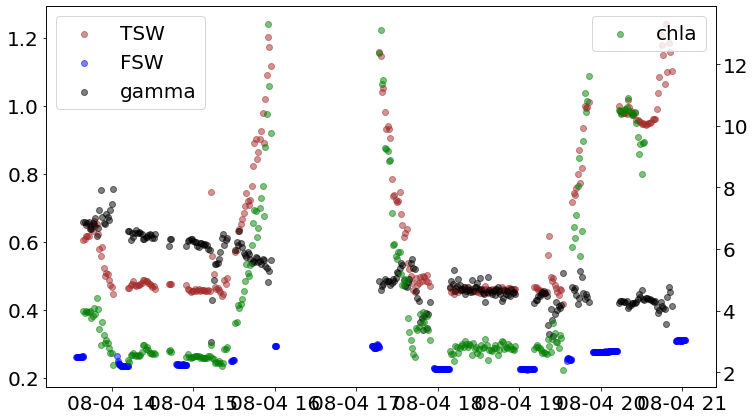

In [116]:
fig, ax = plt.subplots(figsize=(12,7))
for i in range(acs_tsw_bin_np.shape[0]):
    ax.scatter(acs_dt[i], acs_tsw_bin_np[i,10], color='brown', alpha=0.5, label='TSW' if i == 0 else "")

for i in range(acs_fsw_bin_np.shape[0]):
    ax.scatter(acs_fsw_dt[i], acs_fsw_bin_np[i,10], color='blue', alpha=0.5, label='FSW'if i == 0 else "")
    
gamma = pd.read_csv('data/ACS94_20210804_prod_p.csv').iloc[:,344].to_numpy()

for i in range(gamma.shape[0]):
    ax.scatter(acs_dt[i], gamma[i], color='black', alpha=0.5, label='gamma'if i == 0 else "")
    
ax.legend()


ax2 = ax.twinx()   
for i in range(acs_fsw_bin_np.shape[0]):
    ax2.scatter(acs_dt[i], abs_line_chla[i], color='green', alpha=0.5, label='chla'if i == 0 else "")
#ax2.set_title('Absorption Line Height Based Chla at ' + str(acs_wavelength[10]) + 'nm')

ax2.legend()

Connect the TSG lat and lon data to the ACS data via time and plot out the chla on the map

Find the nearest point in time and make that the lat/lon of the ACS datapoint

add lat, lon, chla as a column to the original df as well as time

In [32]:
tsg_df = tsg_df.set_index('pydt')

In [33]:
tsg_df.iloc[tsg_df.index.get_loc(acs_tsw_df.iloc[100].pydt, method='nearest')].lon

-69.9707002272727

In [34]:
# loop through all ACS rows and add the S and T and lat and lon to the dataframe
S = []
T = []
lat = []
lon = []
for i in range(len(acs_tsw_df)):
    row = tsg_df.iloc[tsg_df.index.get_loc(acs_tsw_df.iloc[i].pydt, method='nearest')]
    S.append(row.s)
    T.append(row.t)
    lat.append(row.lat)
    lon.append(row.lon)

In [35]:
acs_tsw_df['chla_lh'] = abs_line_chla
acs_tsw_df['s'] = S
acs_tsw_df['t'] = T
acs_tsw_df['lat'] = lat
acs_tsw_df['lon'] = lon

In [36]:
acs_tsw_df.hvplot.points('lon', 'lat', geo=True, c='chla_lh', alpha=0.2, cmap='viridis', tiles='CartoLight', width=300, height=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (chla_lh)

In [37]:
acs_tsw_gdf = gpd.GeoDataFrame(
    acs_tsw_df, geometry=gpd.points_from_xy(x=acs_tsw_df.lon, y=acs_tsw_df.lat)
)

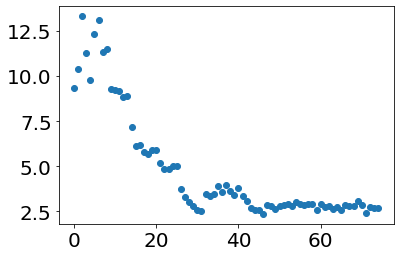

In [38]:
plt.scatter(np.arange(len(acs_tsw_gdf.iloc[100:175])),acs_tsw_gdf['chla_lh'].iloc[100:175])

In [39]:
import contextily as ctx


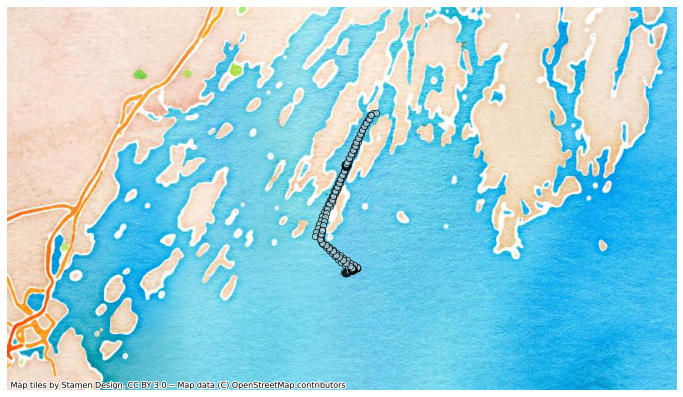

In [92]:
acs_tsw_gdf.crs = 4326  # this line
map_df = acs_tsw_gdf.to_crs(epsg=3857)

ax = map_df.plot(figsize=(12, 10), alpha=0.7, facecolor='lightblue', edgecolor='black', markersize=40)

ax.set_ylim(5.406e6,5.4443e6)

ax.set_xlim(-7.825e6,-7.758e6)

ax.set_axis_off()
ctx.add_basemap(ax, zoom=11, source=ctx.providers.Stamen.Watercolor)
plt.savefig('survey_overview.png')

In [105]:
map_df['gamma'] = pd.read_csv('data/ACS94_20210804_prod_p.csv').iloc[:,344]

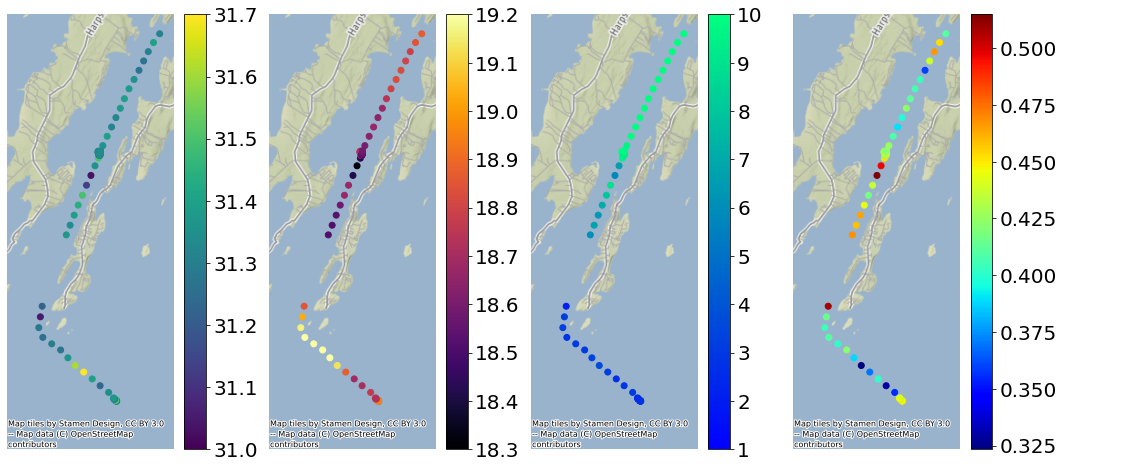

In [108]:
fig, ax = plt.subplots(1,4, figsize=(18,8))

map_df.iloc[175:].plot('s',ax=ax[0], vmin=31, vmax=31.7, legend=True)
map_df.iloc[175:].plot('t',ax=ax[1], cmap='inferno', vmin=18.3, vmax=19.2, legend=True)
map_df.iloc[175:].plot('chla_lh',ax=ax[2], cmap='winter', vmin=1, vmax=10, legend=True)
map_df.iloc[175:].plot('gamma',ax=ax[3], cmap='jet', legend=True)


ax[0].set_ylim(5.416e6,5.4343e6)
ax[1].set_ylim(5.416e6,5.4343e6)
ax[2].set_ylim(5.416e6,5.4343e6)
ax[3].set_ylim(5.416e6,5.4343e6)

ax[0].set_xlim(-7.795e6,-7.788e6)
ax[1].set_xlim(-7.795e6,-7.788e6)
ax[2].set_xlim(-7.795e6,-7.788e6)
ax[3].set_xlim(-7.795e6,-7.788e6)

ctx.add_basemap(ax[0], zoom=12, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax[1], zoom=12, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax[2], zoom=12, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax[3], zoom=12, source=ctx.providers.Stamen.Terrain)


ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()

# fig.tight_layout()
#fig.savefig('afternoon_return.png')

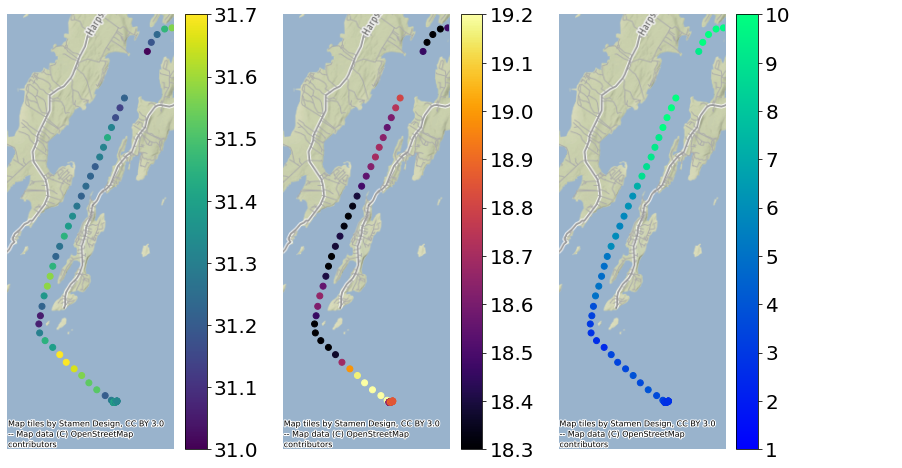

In [43]:
fig, ax = plt.subplots(1,3, figsize=(14,8))

map_df.iloc[100:175].plot('s',ax=ax[0], vmin=31, vmax=31.7, legend=True)
map_df.iloc[100:175].plot('t',ax=ax[1], cmap='inferno', vmin=18.3, vmax=19.2, legend=True)
map_df.iloc[100:175].plot('chla_lh',ax=ax[2], cmap='winter', vmin=1, vmax=10, legend=True)

ax[0].set_ylim(5.416e6,5.4343e6)
ax[1].set_ylim(5.416e6,5.4343e6)
ax[2].set_ylim(5.416e6,5.4343e6)

ax[0].set_xlim(-7.795e6,-7.788e6)
ax[1].set_xlim(-7.795e6,-7.788e6)
ax[2].set_xlim(-7.795e6,-7.788e6)

ctx.add_basemap(ax[0], zoom=12, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax[1], zoom=12, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax[2], zoom=12, source=ctx.providers.Stamen.Terrain)


ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

# fig.tight_layout()

fig.savefig('afternoon_embark.png')

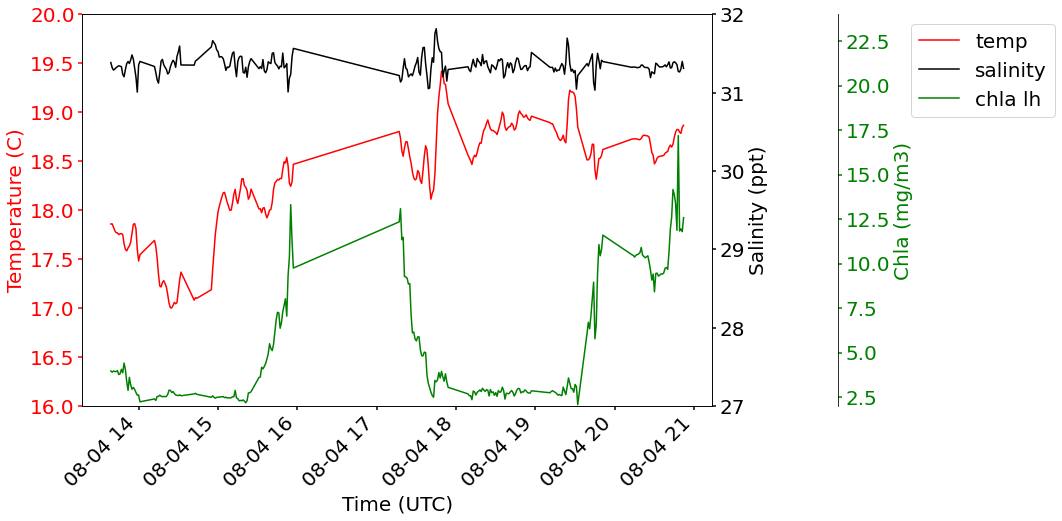

In [47]:
import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots(figsize=(14,8))
fig.subplots_adjust(right=0.75)

fig.autofmt_xdate(rotation=45)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

# p1, = host.plot([0, 1, 2], [0, 1, 2], "b-", label="Density")
# p2, = par1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
# p3, = par2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")

p1, = host.plot(acs_tsw_gdf['pydt'],acs_tsw_gdf['t'], color='red', label='temp')
p2, = par1.plot(acs_tsw_gdf['pydt'],acs_tsw_gdf['s'], color='black', label='salinity')
p3, = par2.plot(acs_tsw_gdf['pydt'],acs_tsw_gdf['chla_lh'], color='green', label='chla lh')

# host.set_xlim(0, 2)
host.set_ylim(16, 20)
par1.set_ylim(27, 32)
par2.set_ylim(2, 24)

host.set_xlabel("Time (UTC)")
host.set_ylabel("Temperature (C)")
par1.set_ylabel("Salinity (ppt)")
par2.set_ylabel("Chla (mg/m3)")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines], bbox_to_anchor=(1.3, 1), loc=2)
plt.savefig('cruise_overview.png',dpi=300)
plt.show()

In [48]:
acs_part_bin_np.shape

(267, 81)

In [ ]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(acs_part_bin_np)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(acs_part_bin_np)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
        curr_center = centroids[pred_clusters[i]]
        curr_see = []
        for j in acs_part_bin_np.shape[1]:
            (acs_part_bin_np[i, 0] - curr_center[0]) ** 2 + (acs_part_bin_np[i, 1] - acs_part_bin_np[1]) ** 2
        curr_sse +=
    sse.append(curr_sse)
  return sse

In [49]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(acs_part_bin_np)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [93]:

colors = ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in kmeans.labels_]

In [94]:
acs_tsw_gdf['cluster'] = kmeans.labels_

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


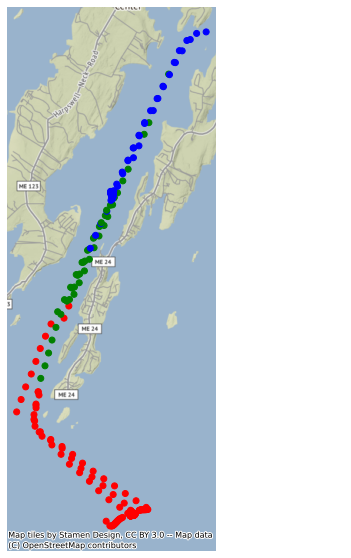

In [95]:
acs_tsw_gdf.crs = 4326  # this line
map_df = acs_tsw_gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(10, 10))

ax = map_df.plot('cluster',color=colors,ax=ax)
ctx.add_basemap(ax, zoom=13, source=ctx.providers.Stamen.Terrain)
ax.set_axis_off()

fig.savefig('clusters_geo.png')

In [469]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
reduced_x = pca.fit_transform(acs_part_bin_np)

In [470]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(acs_part_bin_np)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [471]:
reduced_x.shape

(267, 5)

In [472]:
kmeans.cluster_centers_.shape

(2, 81)

In [480]:
sns.color_palette("Set1", n_colors=3)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


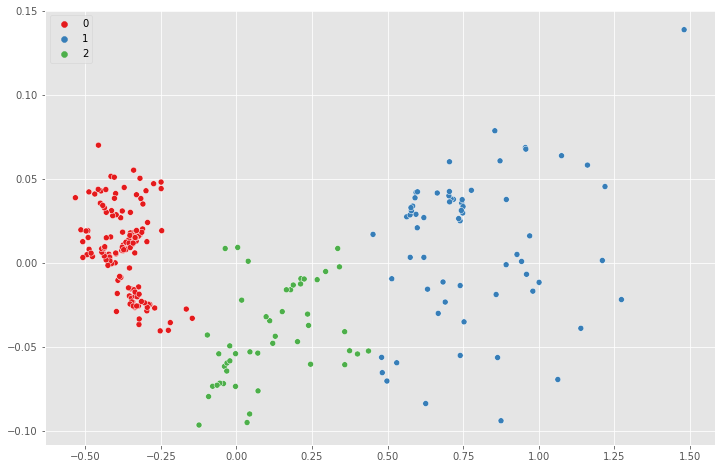

In [498]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
# plot the cluster centers and samples 
# sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
#                 marker='+', 
#                 color='black', 
#                 s=200);
sns.scatterplot(reduced_x[:,0], reduced_x[:,1], hue=kmeans.labels_, 
                palette=sns.color_palette("Set1", n_colors=3),ax=ax);

plt.savefig('clusters.png')